# plot_comparison.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 06 November 2023

Purpose: Read in all cases to plot comparisons between them

In [1]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn
import cmocean
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

### Settings

In [2]:
# directory to save figures
figdir = "/home/rfrost/manuscript_plots/"
# simulation to analyze
sims = ["full_step_6", "full_step_9", "full_step_12", "full_step_15"]

# z/zi to plot
height = 0.25

# start and end timesteps
t0 = 576000
t1 = 1152000
# start and end in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600
# spacing of output
dt = 1000

# lists to store stats, roll factor, and length scales
s_all, r_all, ls_all = [], [], []
# loop over sims
for sim in sims:
    dnc = f"/home/rfrost/simulations/nc/{sim}/"
    # volumetric stats
    s = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
    # convert time to hours
    s["time"] = s.time / 3600 + t0hr
    s_all.append(s)

    # roll factor
    r = xr.open_dataset(f"{dnc}rollfactor.nc")
    # convert time to hours
    r["time"] = r.time / 3600 + t0hr
    r_all.append(r)

    # length scales
    ls = xr.open_dataset(f"{dnc}{t0}_{t1}_length_scale_rot.nc")
    # convert time to hours
    ls["time"] = ls.time / 3600 + t0hr
    ls_all.append(ls)

In [3]:
# plotting setup

# Set the font weight for plot titles
plt.rcParams['axes.titleweight'] = 'bold'

# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='sans-serif')
rc('font', weight='normal', size=20)
rc('figure', facecolor='white') 

In [4]:
# find average T_L at hr 9.8333
T_L = (843.69 + 861.95 + 841.57 + 844.23) / 4

tb = -2
tc = 4.5
td = 11
te = 17.5
tf = 24

tlmax = max((s_all[0].time-10)*3600/T_L)
tlmin = min((s_all[0].time-10)*3600/T_L)

# normalized times to be plot
jttl = [-2, 4.5, 11, 17.5, 24]
jtall = [abs(((s_all[0].time.values-10)*3600)/T_L - jttl[jt]).argmin() for jt in range(len(jttl))]

In [5]:
# calculate TKE and theta*
for i, s in enumerate(s_all):
    s["tke"] = (1/2) * (s.uu_var + s.vv_var + s.ww_var)
    s["thetastar"] = s.tw_cov_tot[:,0] / s.wstar

### Vertical profiles of heat and momentum fluxes

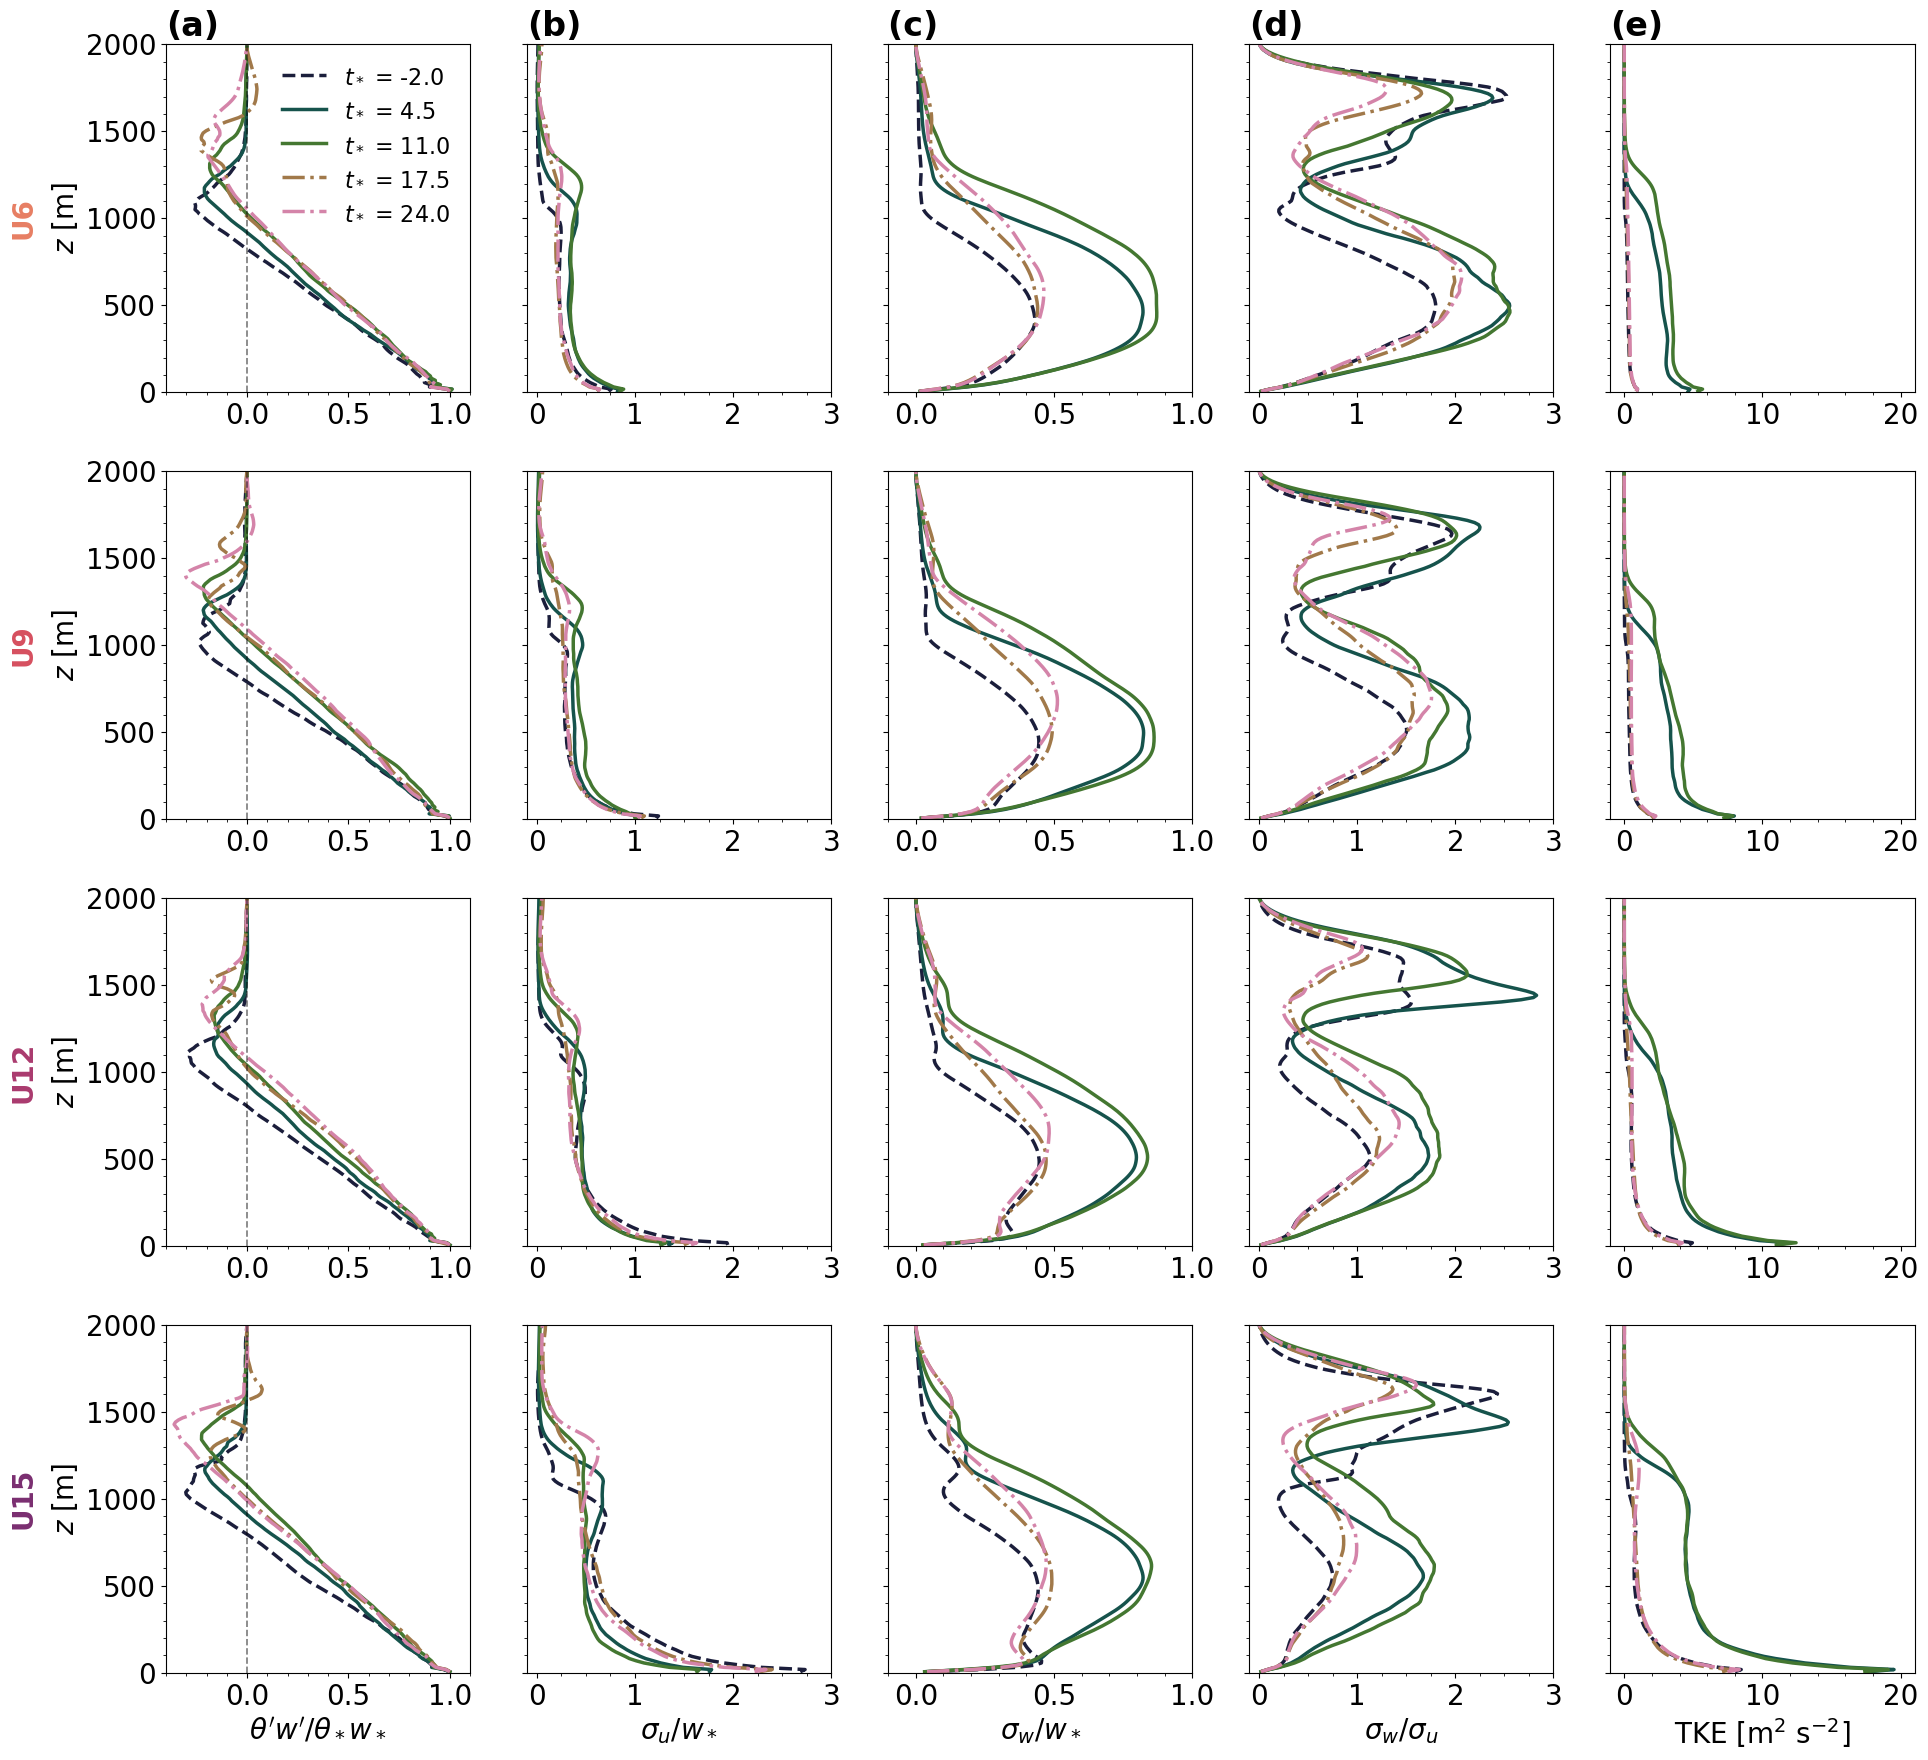

In [6]:
# colormap
time_colors = seaborn.color_palette("cubehelix", 7)
ug_colors = seaborn.color_palette("flare", 4)
# line styles
linestyle = ["--","solid","solid","-.","-."]

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(19.5,18), sharey=True)

# normalized heat flux
axes = [ax[0, 0], ax[1, 0], ax[2, 0], ax[3, 0]]
for i in range(len(jtall)):
    time_values = [s_all[j].time[jtall[i]].values for j in range(4)]
    tw_cov_tot_values = [s_all[j].tw_cov_tot[jtall[i]] for j in range(4)]
    thetastar_values = [s_all[j].thetastar for j in range(4)]
    wstar_values = [s_all[j].wstar for j in range(4)]
    z_values = [s_all[j].z for j in range(4)]
    labels = [f"$t_*$ = {round(((time_values[j]-10)*3600)/T_L,1)}" for j in range(4)]
    for j in range(4):
        axes[j].plot(tw_cov_tot_values[j] / (thetastar_values[j] * wstar_values[j]).isel(time=jtall[i]), z_values[j], 
                     c=time_colors[i], label=labels[j], lw=2.5, ls=linestyle[i])
        axes[j].set_xlim(-0.4, 1.1)
        axes[j].xaxis.set_minor_locator(MultipleLocator(0.1))

# u variance
axes = [ax[0, 1], ax[1, 1], ax[2, 1], ax[3, 1]]
for i in range(len(jtall)):
    u_var_values = [s_all[j].u_var_rot[jtall[i]] for j in range(4)]
    wstar_values = [s_all[j].wstar for j in range(4)]
    z_values = [s_all[j].z for j in range(4)]
    for j in range(4):
        axes[j].plot(u_var_values[j] / (wstar_values[j]).isel(time=jtall[i]), z_values[j], 
                     c=time_colors[i], lw=2.5, ls=linestyle[i])
        axes[j].set_xlim(-0.1, 3)
        axes[j].xaxis.set_minor_locator(MultipleLocator(0.25))
        axes[j].xaxis.set_major_locator(MultipleLocator(1))

# w variance
axes = [ax[0, 2], ax[1, 2], ax[2, 2], ax[3, 2]]
for i in range(len(jtall)):
    w_var_values = [s_all[j].w_var[jtall[i]] for j in range(4)]
    wstar_values = [s_all[j].wstar for j in range(4)]
    z_values = [s_all[j].z for j in range(4)]
    for j in range(4):
        axes[j].plot(w_var_values[j] / (wstar_values[j]).isel(time=jtall[i]), z_values[j], 
                     c=time_colors[i], lw=2.5, ls=linestyle[i])
        axes[j].set_xlim(-0.1, 1)
        axes[j].xaxis.set_minor_locator(MultipleLocator(0.1))
        axes[j].xaxis.set_major_locator(MultipleLocator(0.5))

# w_var / u_var
axes = [ax[0, 3], ax[1, 3], ax[2, 3], ax[3, 3]]
for i in range(len(jtall)):
    w_var_values = [s_all[j].w_var[jtall[i]] for j in range(4)]
    u_var_values = [s_all[j].u_var_rot[jtall[i]] for j in range(4)]
    z_values = [s_all[j].z for j in range(4)]
    for j in range(4):
        axes[j].plot(w_var_values[j] / u_var_values[j], z_values[j], 
                     c=time_colors[i], lw=2.5, ls=linestyle[i])
        axes[j].set_xlim(-0.1, 3)
        axes[j].xaxis.set_minor_locator(MultipleLocator(0.25))
        axes[j].xaxis.set_major_locator(MultipleLocator(1))

# TKE
axes = [ax[0, 4], ax[1, 4], ax[2, 4], ax[3, 4]]
for i in range(len(jtall)):
    tke_values = [s_all[j].tke[jtall[i]] for j in range(4)]
    z_values = [s_all[j].z for j in range(4)]
    for j in range(4):
        axes[j].plot(tke_values[j] ** 2, z_values[j], 
                     c=time_colors[i], lw=2.5, ls=linestyle[i])
        axes[j].set_xlim(-1,21)
        axes[j].xaxis.set_minor_locator(MultipleLocator(2))

# xaxis labels
ax[3,0].set_xlabel("$\\theta'w' / \\theta_*w_*$")
ax[3,1].set_xlabel("$\sigma_u / w_*$")
ax[3,2].set_xlabel("$\sigma_w / w_*$")
ax[3,3].set_xlabel("$\sigma_w / \sigma_u$")
ax[3,4].set_xlabel("TKE [m$^2$ s$^{-2}$]")

case = ["6", "9", "12", "15"]
for i, iax in enumerate(ax[:,0]):
    iax.set_ylabel("$z$ [m]")
    iax.set_ylim(0,2000)
    iax.axvline(x=0, ls="--", alpha=0.5, lw=1.25, color="black")
    iax.yaxis.set_minor_locator(MultipleLocator(100))
    iax.yaxis.set_major_locator(MultipleLocator(500))
    iax.text(-1.1, 1000, f"U{case[i]}", 
            rotation=90, fontsize=20, va="center", ha="center", weight="bold", c=ug_colors[i])

# axis titles
ax[0,0].set_title("(a)", loc="left")
ax[0,1].set_title("(b)", loc="left")
ax[0,2].set_title("(c) ", loc="left")
ax[0,3].set_title("(d)", loc="left")
ax[0,4].set_title("(e)", loc="left")

plt.subplots_adjust(hspace=0.3)

ax[0,0].legend(frameon=False, fontsize=16, loc="upper right")

plt.tight_layout()
plt.savefig(f"{figdir}fig3.pdf", format="pdf", dpi=300, bbox_inches="tight")

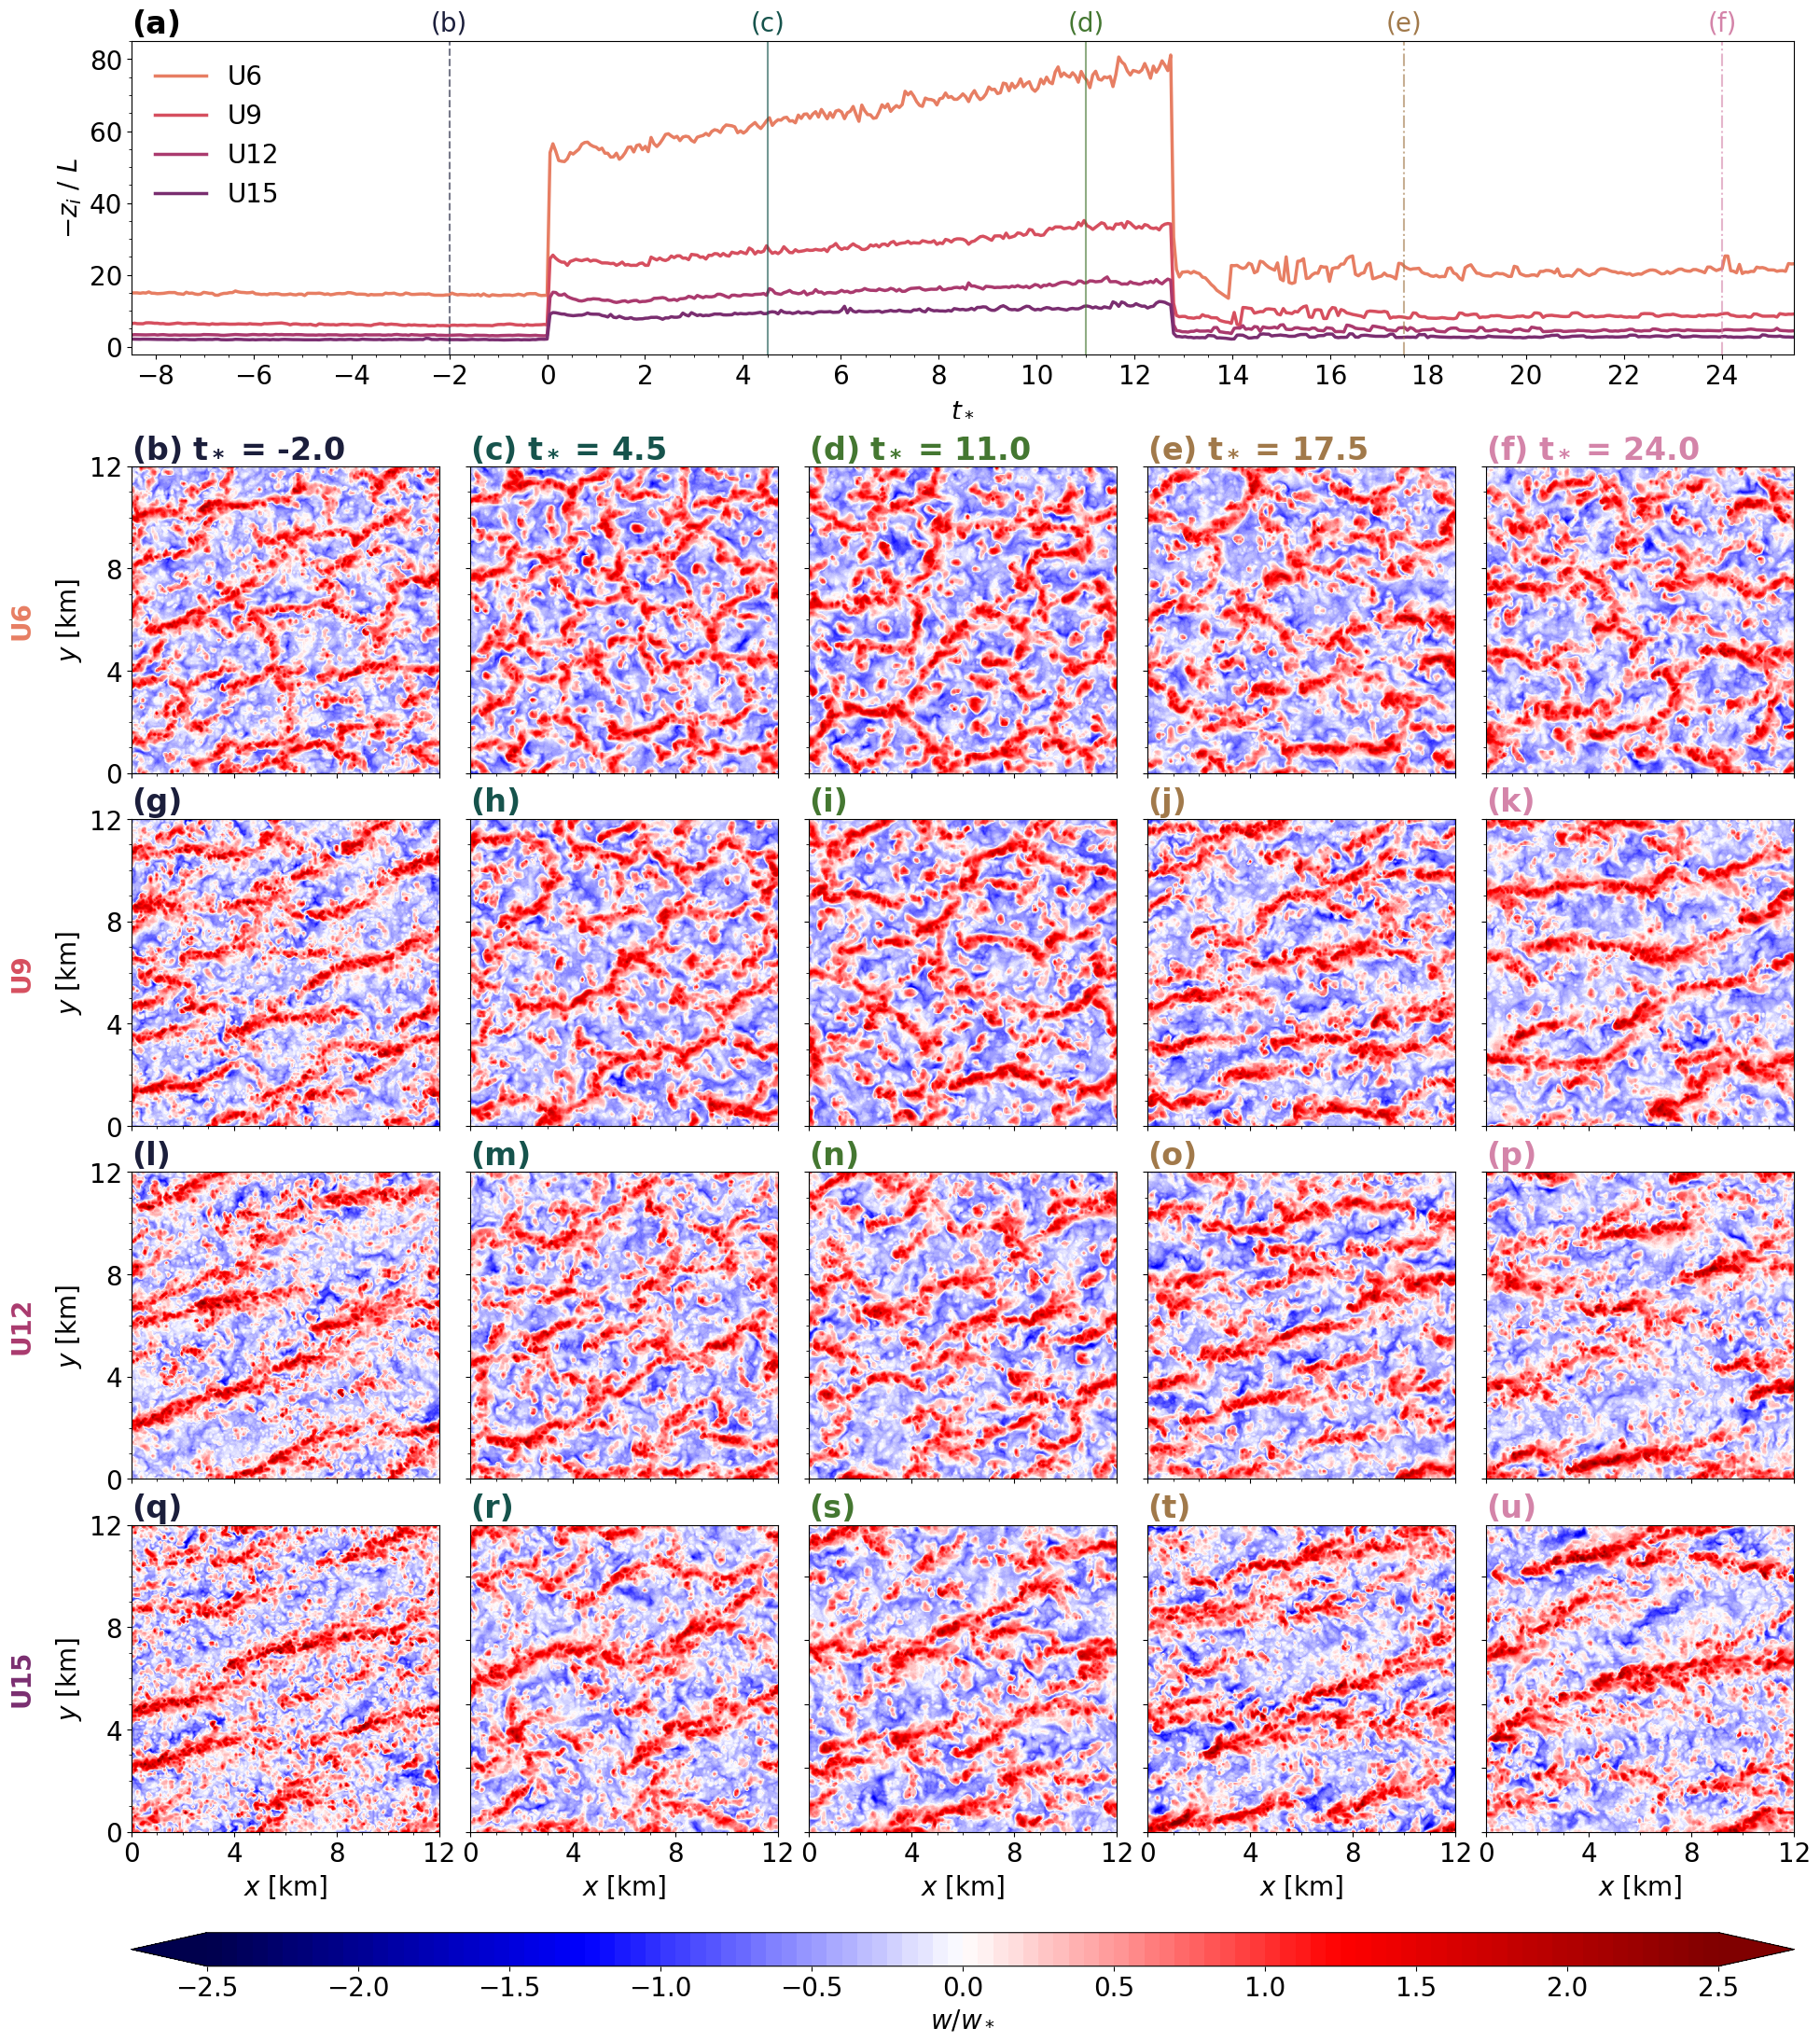

In [7]:
fig = plt.figure(figsize=(23,24))

gs1 = GridSpec(1, 1, bottom=0.74)
ax1 = fig.add_subplot(gs1[:,:])
gs2 = GridSpec(4, 5, top=0.69, bottom=0.08)
ax2 = fig.add_subplot(gs2[0,0])
ax3 = fig.add_subplot(gs2[0,1])
ax4 = fig.add_subplot(gs2[0,2])
ax5 = fig.add_subplot(gs2[0,3])
ax6 = fig.add_subplot(gs2[0,4])
ax7 = fig.add_subplot(gs2[1,0])
ax8 = fig.add_subplot(gs2[1,1])
ax9 = fig.add_subplot(gs2[1,2])
ax10 = fig.add_subplot(gs2[1,3])
ax11 = fig.add_subplot(gs2[1,4])
ax12 = fig.add_subplot(gs2[2,0])
ax13 = fig.add_subplot(gs2[2,1])
ax14 = fig.add_subplot(gs2[2,2])
ax15 = fig.add_subplot(gs2[2,3])
ax16 = fig.add_subplot(gs2[2,4])
ax17 = fig.add_subplot(gs2[3,0])
ax18 = fig.add_subplot(gs2[3,1])
ax19 = fig.add_subplot(gs2[3,2])
ax20 = fig.add_subplot(gs2[3,3])
ax21 = fig.add_subplot(gs2[3,4])
gs3 = GridSpec(1,1, top=0.035, bottom=0.02)
ax22 = fig.add_subplot(gs3[:,:])

# zi/L time series
ug_list = ["6", "9", "12", "15"]
for i, s in enumerate(s_all):
    ax1.plot(((s.time - 10)*3600) / T_L, s.zi_L, c=ug_colors[i], 
             label=f"U{case[i]}", lw=2.5)
ax1.set_xlim(tlmin,tlmax)
ax1.legend(frameon=False, fontsize=20)
# vertical lines
ax1.axvline(x=tb, lw=1.5, alpha=0.6, ls=linestyle[0], c=time_colors[0])
ax1.axvline(x=tc, lw=1.5, alpha=0.6, ls=linestyle[1], c=time_colors[1])
ax1.axvline(x=td, lw=1.5, alpha=0.6, ls=linestyle[2], c=time_colors[2])
ax1.axvline(x=te, lw=1.5, alpha=0.6, ls=linestyle[3], c=time_colors[3])
ax1.axvline(x=tf, lw=1.5, alpha=0.6, ls=linestyle[4], c=time_colors[4])
# text above lines
ax1.text(tb, 90, "(b)", ha="center", va="center", c=time_colors[0])
ax1.text(tc, 90, "(c)", ha="center", va="center", c=time_colors[1])
ax1.text(td, 90, "(d)", ha="center", va="center", c=time_colors[2])
ax1.text(te, 90, "(e)", ha="center", va="center", c=time_colors[3])
ax1.text(tf, 90, "(f)", ha="center", va="center", c=time_colors[4])
# ticks
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
# axis label
ax1.set_xlabel("$t_*$")
ax1.set_ylabel("$-z_i$ $/$ $L$")
# title
ax1.set_title("(a)", loc="left")

# contourf plots
clevs = np.linspace(-2.5,2.5,101)
# 6 m/s
sim = 0
axes = [ax2, ax3, ax4, ax5, ax6]
time_values = [s_all[sim].time[jtall[i]].values for i in range(len(jtall))]
w_values = [s_all[sim].w[jtall[i]] for i in range(len(jtall))]
wstar_values = [s_all[sim].wstar[jtall[i]] for i in range(len(jtall))]
x_values = s_all[sim].x
y_values = s_all[sim].y
lab = ["b", "c", "d", "e", "f"]
for j in range(5):
    jz = abs(s_all[0].z/s_all[0].zi[jtall[j]] - height).argmin()
    cf = axes[j].contourf(x_values/1000, y_values/1000, w_values[j][:,:,jz].T / wstar_values[j],
                     cmap=mpl.cm.seismic, levels=clevs, extend="both")
    axes[j].xaxis.set_major_locator(MultipleLocator(4))
    axes[j].xaxis.set_minor_locator(MultipleLocator(1))
    axes[j].yaxis.set_major_locator(MultipleLocator(4))
    axes[j].yaxis.set_minor_locator(MultipleLocator(1))
    axes[j].set_title(f"({lab[j]}) $\\bf{{t_*}}$ = {round(((s_all[0].time[jtall[j]].values-10)*3600)/T_L,1)}", loc="left", c=time_colors[j])
    # Manually rasterize each collection in the ContourSet
    for collection in cf.collections:
        collection.set_rasterized(True)

# 9 m/s
sim = 1
axes = [ax7, ax8, ax9, ax10, ax11]
time_values = [s_all[sim].time[jtall[i]].values for i in range(len(jtall))]
w_values = [s_all[sim].w[jtall[i]] for i in range(len(jtall))]
wstar_values = [s_all[sim].wstar[jtall[i]] for i in range(len(jtall))]
x_values = s_all[sim].x
y_values = s_all[sim].y
lab = ["g", "h", "i", "j", "k"]
for j in range(5):
    jz = abs(s_all[1].z/s_all[1].zi[jtall[j]] - height).argmin()
    cf = axes[j].contourf(x_values/1000, y_values/1000, w_values[j][:,:,jz].T / wstar_values[j],
                     cmap=mpl.cm.seismic, levels=clevs, extend="both")
    axes[j].xaxis.set_major_locator(MultipleLocator(4))
    axes[j].xaxis.set_minor_locator(MultipleLocator(1))
    axes[j].yaxis.set_major_locator(MultipleLocator(4))
    axes[j].yaxis.set_minor_locator(MultipleLocator(1))
    axes[j].set_title(f"({lab[j]})", loc="left", c=time_colors[j])
    # Manually rasterize each collection in the ContourSet
    for collection in cf.collections:
        collection.set_rasterized(True)

# 12 m/s
sim = 2
axes = [ax12, ax13, ax14, ax15, ax16]
time_values = [s_all[sim].time[jtall[i]].values for i in range(len(jtall))]
w_values = [s_all[sim].w[jtall[i]] for i in range(len(jtall))]
wstar_values = [s_all[sim].wstar[jtall[i]] for i in range(len(jtall))]
x_values = s_all[sim].x
y_values = s_all[sim].y
lab = ["l", "m", "n", "o", "p"]
for j in range(5):
    jz = abs(s_all[2].z/s_all[2].zi[jtall[j]] - height).argmin()
    cf = axes[j].contourf(x_values/1000, y_values/1000, w_values[j][:,:,jz].T / wstar_values[j],
                     cmap=mpl.cm.seismic, levels=clevs, extend="both")
    axes[j].xaxis.set_major_locator(MultipleLocator(4))
    axes[j].xaxis.set_minor_locator(MultipleLocator(1))
    axes[j].yaxis.set_major_locator(MultipleLocator(4))
    axes[j].yaxis.set_minor_locator(MultipleLocator(1))
    axes[j].set_title(f"({lab[j]})", loc="left", c=time_colors[j])
    # Manually rasterize each collection in the ContourSet
    for collection in cf.collections:
        collection.set_rasterized(True)

# 15 m/s
sim = 3
axes = [ax17, ax18, ax19, ax20, ax21]
time_values = [s_all[sim].time[jtall[i]].values for i in range(len(jtall))]
w_values = [s_all[sim].w[jtall[i]] for i in range(len(jtall))]
wstar_values = [s_all[sim].wstar[jtall[i]] for i in range(len(jtall))]
x_values = s_all[sim].x
y_values = s_all[sim].y
lab = ["q", "r", "s", "t", "u"]
for j in range(5):
    jz = abs(s_all[3].z/s_all[3].zi[jtall[j]] - height).argmin()
    cf = axes[j].contourf(x_values/1000, y_values/1000, w_values[j][:,:,jz].T / wstar_values[j],
                     cmap=mpl.cm.seismic, levels=clevs, extend="both")
    axes[j].xaxis.set_major_locator(MultipleLocator(4))
    axes[j].xaxis.set_minor_locator(MultipleLocator(1))
    axes[j].set_xlabel("$x$ [km]")
    axes[j].set_title(f"({lab[j]})", loc="left", c=time_colors[j])
    # Manually rasterize each collection in the ContourSet
    for collection in cf.collections:
        collection.set_rasterized(True)

# axis stuff
case = ["6", "9", "12", "15"]
axes = [ax2, ax7, ax12, ax17]
for ax in axes:
    ax.yaxis.set_major_locator(MultipleLocator(4))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylabel("$y$ [km]")
for i, ax in enumerate(axes):
    ax.text(-4.25, 6, f"U{case[i]}", 
            rotation=90, fontsize=20, va="center", ha="center", weight="bold", c=ug_colors[i])
axes = [ax2, ax7, ax12]
for ax in axes:
    ax.set_xticklabels([])
axes = [ax18, ax19, ax20, ax21]
for ax in axes:
    ax.set_yticklabels([])

# Set tick labels to an empty list for inner subplots
for ax in [ax3, ax4, ax5, ax6, ax8, ax9, ax10, ax11, ax13, ax14, ax15, ax16]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

cbar = plt.colorbar(cf, ax22, orientation="horizontal")
cbar.set_ticks([-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5])
cbar.set_label("$w / w_*$")

plt.subplots_adjust(hspace=0.15, wspace=0.1)

plt.savefig(f"{figdir}fig5.pdf", format="pdf", dpi=300, bbox_inches="tight")

### Print values for table 1 in manuscript

In [8]:
sim = 3 # 0 = 6 m/s, 1 = 9 m/s, and so on
t = 1 # 0 = t0, 1 = t1
ug = [6, 9, 12, 15]
jthr = [9.83333, 12.83333]
jt = abs(s_all[sim].time.values - jthr[t]).argmin()

print(f"Ug = {ug[sim]} m/s, t = {jthr[t]} hr")
print(f"|L| = {round(abs(s_all[sim].L.isel(time=jt).values),2)}")
print(f"-z_i / L = {round(float(s_all[sim].zi_L.isel(time=jt).values),2)}")
print(f"u_* = {round(float(s_all[sim].ustar0.isel(time=jt).values),2)}")
print(f"w_* = {round(float(s_all[sim].wstar.isel(time=jt).values),2)}")
print(f"T_L = {round(float(s_all[sim].zi.isel(time=jt).values/s_all[sim].wstar.isel(time=jt).values),2)}")

Ug = 15 m/s, t = 12.83333 hr
|L| = 112.8
-z_i / L = 11.99
u_* = 0.76
w_* = 2.37
T_L = 569.55
